In [1]:
from google.cloud import language_v1
from nltk.tree import Tree
from IPython import embed
import svgling

In [2]:
client = language_v1.LanguageServiceClient()

In [3]:
# get Google Cloud syntax of sentence
def get_syntax(sentence):
    type_ = language_v1.Document.Type.PLAIN_TEXT

    # Optional. If not specified, the language is automatically detected.
    # For list of supported languages:
    # https://cloud.google.com/natural-language/docs/languages
    language = "en"
    document = {"content": sentence, "type_": type_, "language": language}

    # Available values: NONE, UTF8, UTF16, UTF32
    encoding_type = language_v1.EncodingType.UTF8
    
    syntax = client.analyze_syntax(
        request={"document": document, "encoding_type": encoding_type}
    )
    
    return syntax

In [4]:
# get parent-child structure from dependency relations

def extract_dependency(syntax):
    
    idx_children = {}
    tokens_info = {}
    root_idx = 0
    for idx, token in enumerate(syntax.tokens):
        tokens_info[idx] = token
    
        if str(token.dependency_edge.label)[6:] == "ROOT":
            root_idx = idx
    
        parent_idx = token.dependency_edge.head_token_index
        if parent_idx not in idx_children.keys():
            idx_children[parent_idx] = [idx]
        else:
            idx_children[parent_idx].append(idx)

    for parent_idx in idx_children.keys():
        if parent_idx not in idx_children[parent_idx]:
            idx_children[parent_idx].append(parent_idx)
        idx_children[parent_idx].sort()
    
    return idx_children, tokens_info, root_idx

In [5]:
# convert parent-child structure into NLTK tree

def get_subtree(idx_children, tokens_info, idx, repeat_flag=0):
    token = tokens_info[idx]
    label = str(token.dependency_edge.label)[6:].lower()
    tag = str(token.part_of_speech.tag)[4:]
    word = token.text.content
    
    if repeat_flag == 1:
        return Tree(label, [Tree(tag, [word])])
    
    # if repeat_flag == 0
    if idx in idx_children.keys():
        children = idx_children[idx]
        subtree_list = []
        for child in children:
            if child != idx:
                subtree_list.append(get_subtree(idx_children, tokens_info, child))
            else:
                subtree_list.append(get_subtree(idx_children, tokens_info, idx, repeat_flag=1))
        return Tree(label, subtree_list)
    else:
        return Tree(label, [Tree(tag, [word])])
    

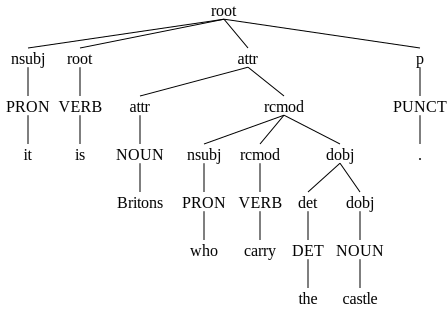

In [6]:
sentence = "it is Britons who carry the castle ."

syntax = get_syntax(sentence)

idx_children, tokens_info, root_idx = extract_dependency(syntax)

parse_tree = get_subtree(idx_children, tokens_info, root_idx)

display(parse_tree)

## For all sentences

In [7]:
def parse_file(text_file, verbose=False):
    """
        returns the most probable parse for sentences in the file
        verbose=True prints errors if cannot parse a sentence
    """
    sentences = []
    with open(text_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('#'):
                continue  # comment
            sentences.append(line)
    
    tree_list = []
    for sentence in sentences:
        
        syntax = get_syntax(sentence)

        idx_children, tokens_info, root_idx = extract_dependency(syntax)

        parse_tree = get_subtree(idx_children, tokens_info, root_idx)

        tree_list.append(parse_tree)
    
    return tree_list

### Base

In [8]:
base_trees_GC = parse_file('./main-data/base-set.sen')

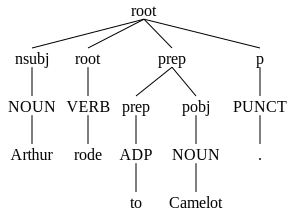

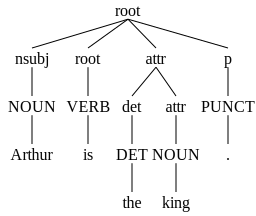

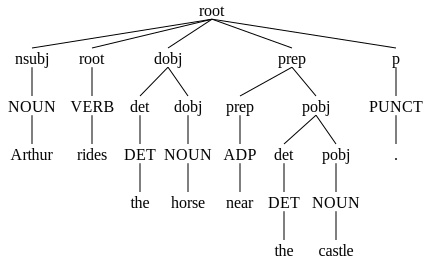

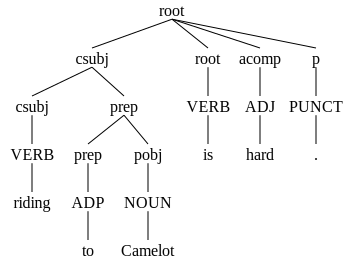

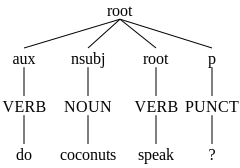

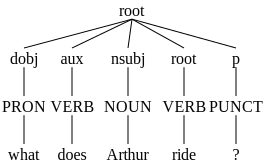

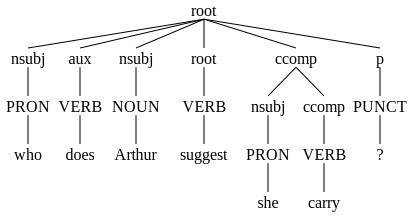

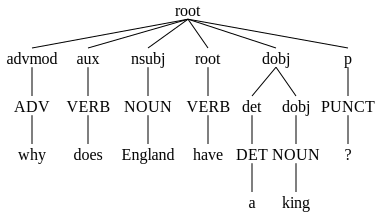

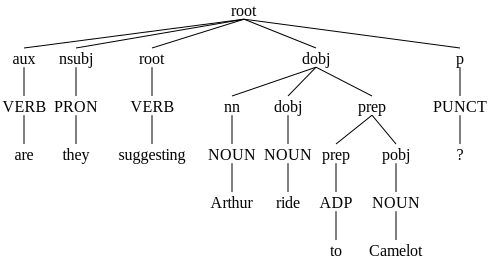

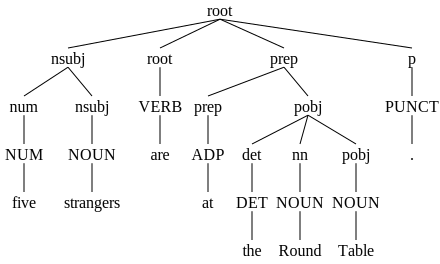

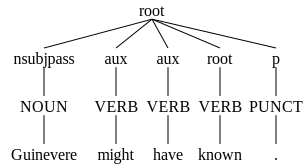

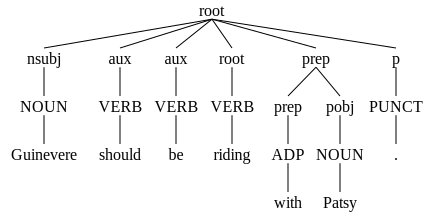

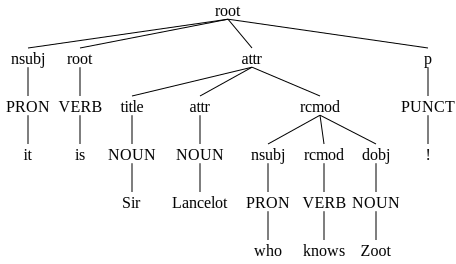

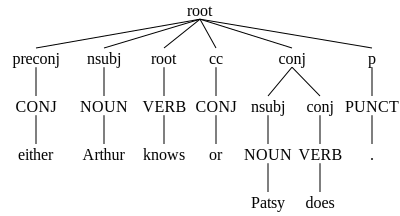

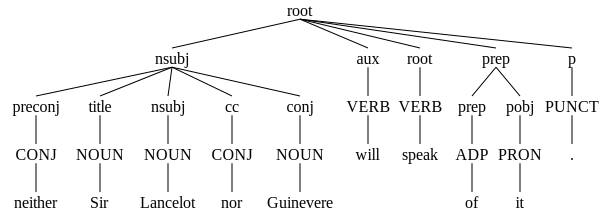

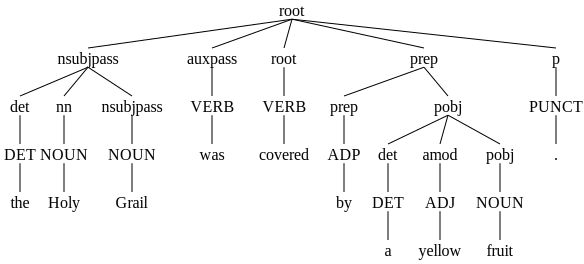

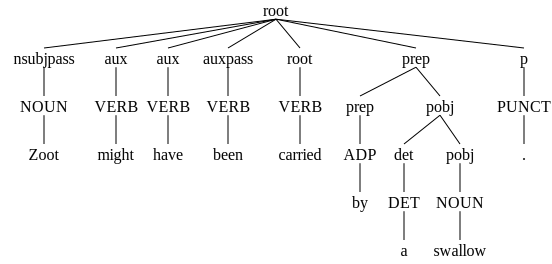

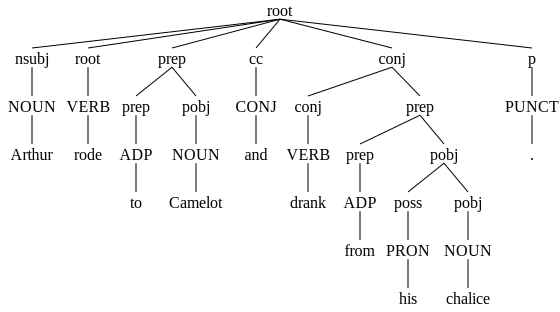

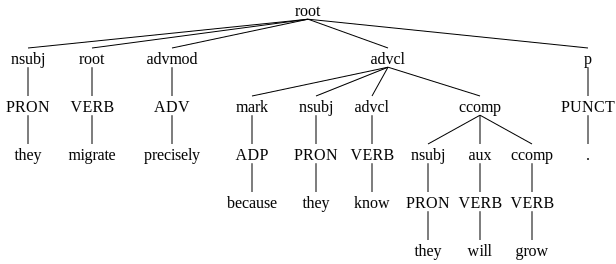

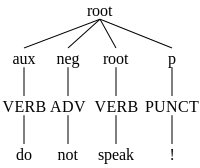

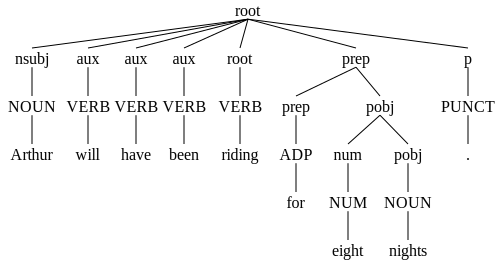

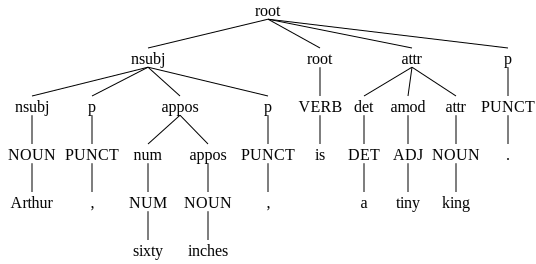

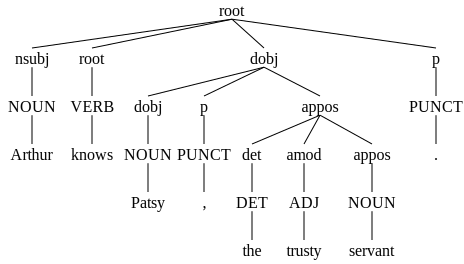

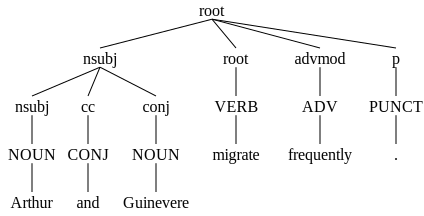

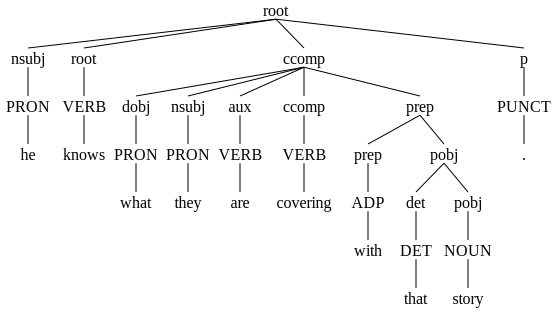

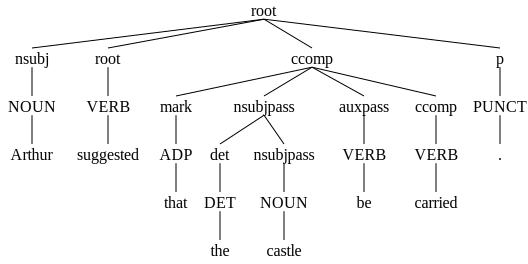

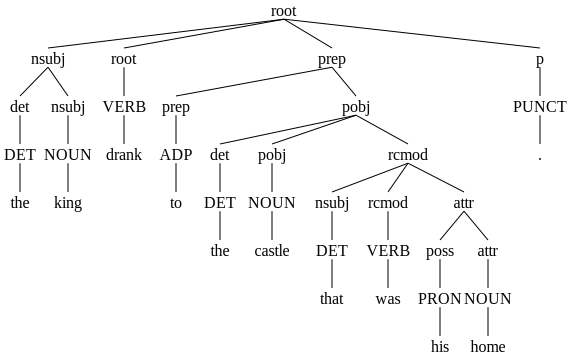

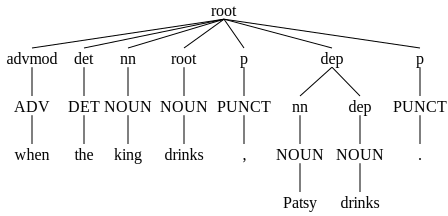

In [9]:
for tree in base_trees_GC:
    display(tree)

In [10]:
import pickle

save_dir = "D:\\MIT\\Courses\\2023-Spring\\6.8630-NLP\\Final Project\\LLM CGW\\All Parse Trees\\Trees"

with open(save_dir+'\\GC_Base_Trees.pkl', 'wb') as f:
    pickle.dump(base_trees_GC, f)

### Adversarial

In [11]:
adversarial_trees_GC = parse_file('./main-data/adversarial_set.sen')

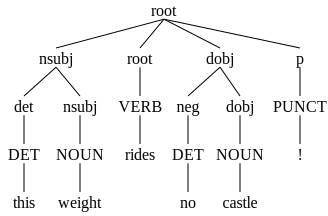

In [12]:
display(adversarial_trees_GC[20])

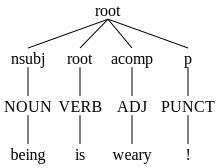

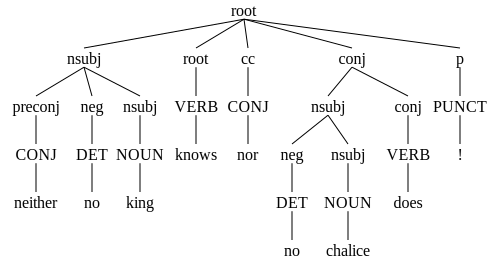

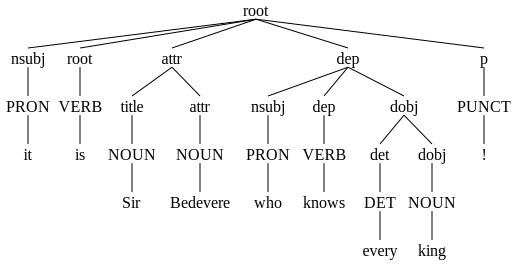

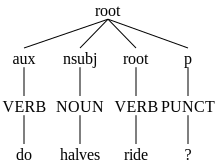

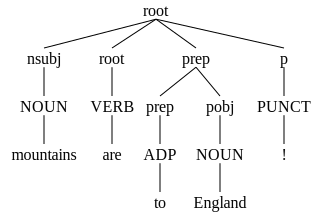

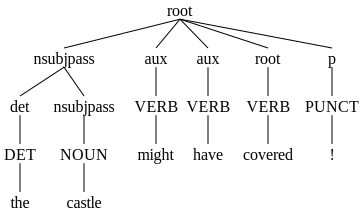

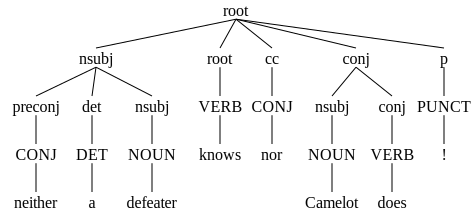

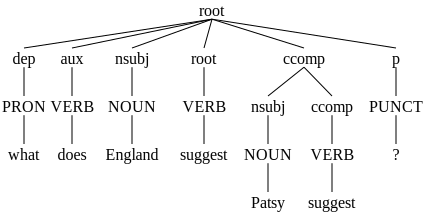

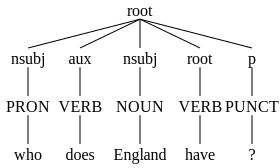

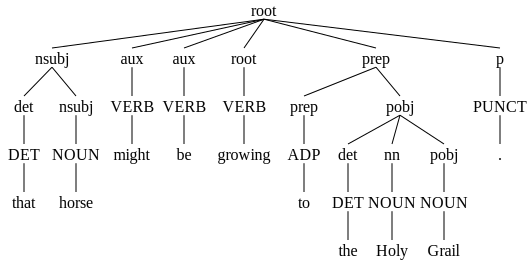

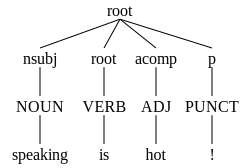

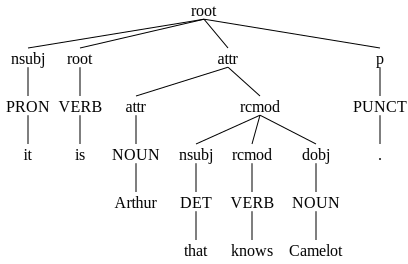

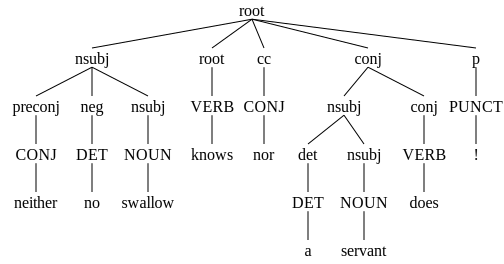

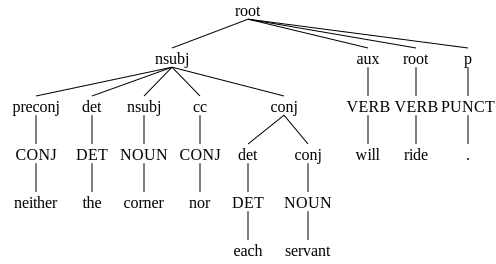

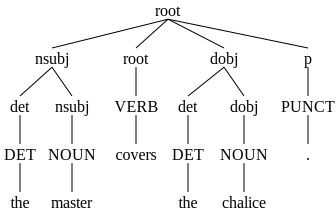

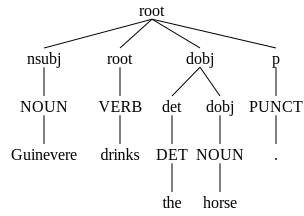

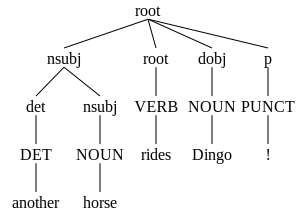

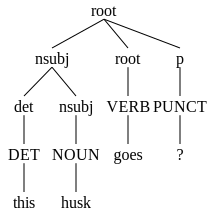

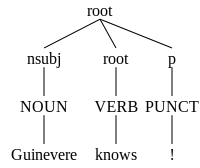

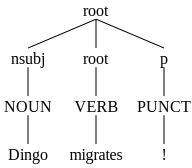

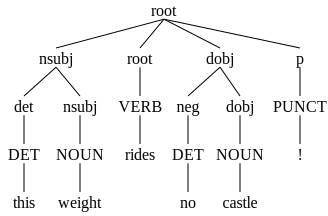

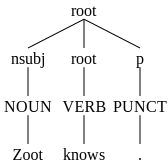

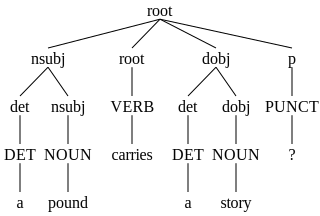

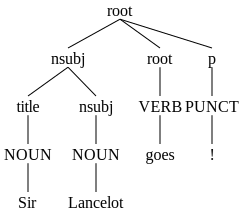

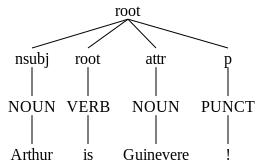

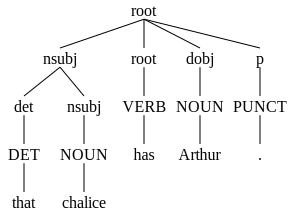

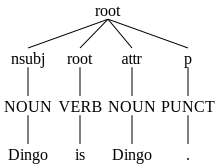

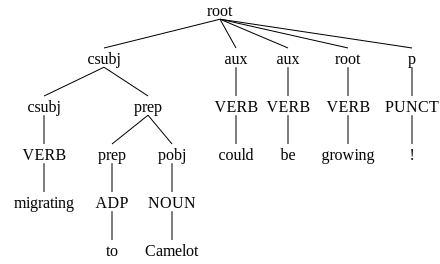

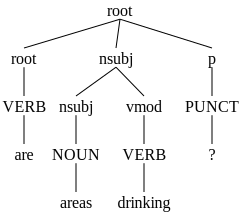

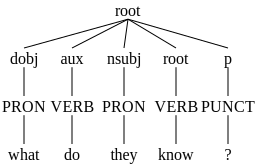

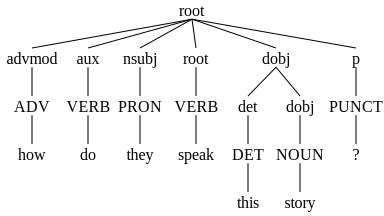

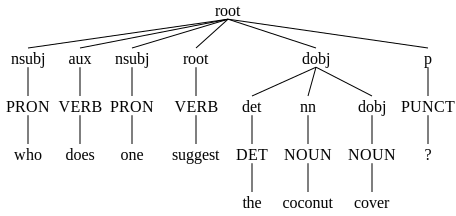

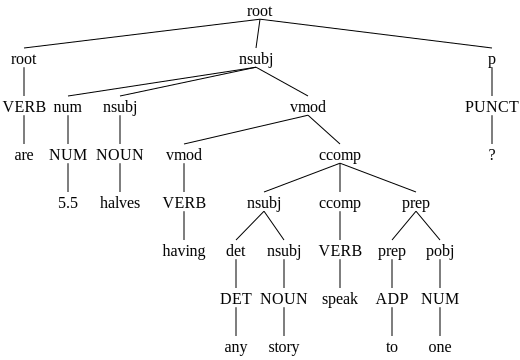

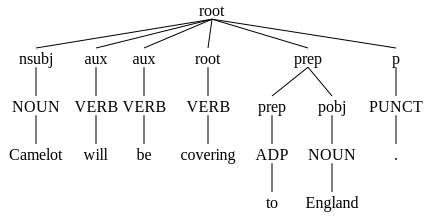

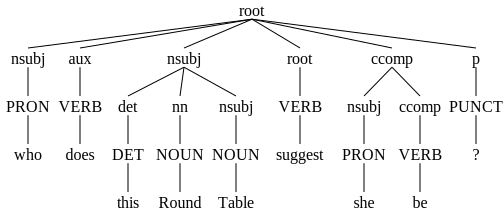

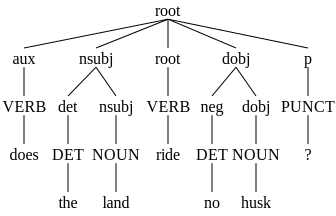

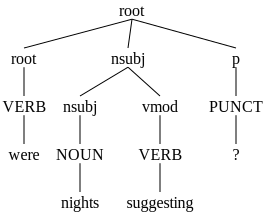

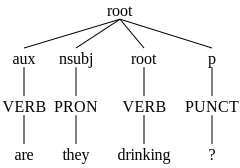

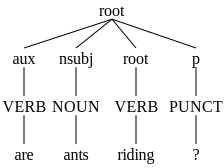

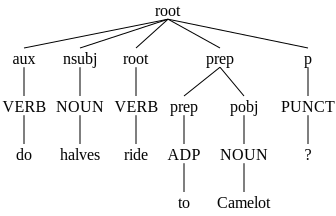

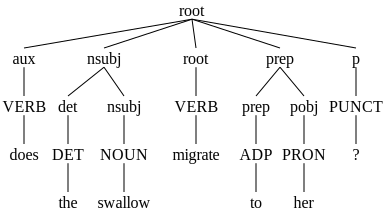

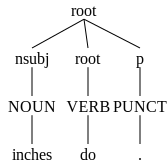

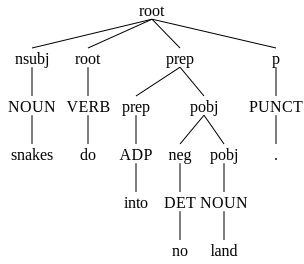

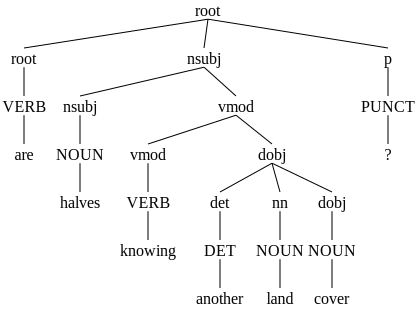

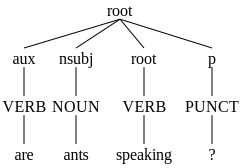

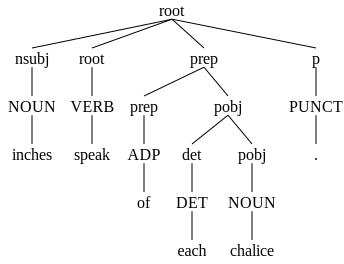

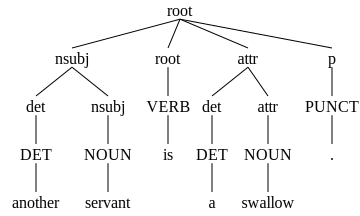

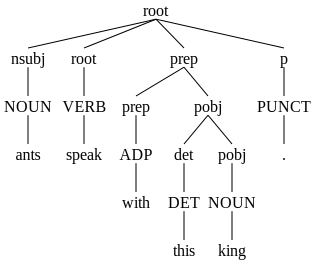

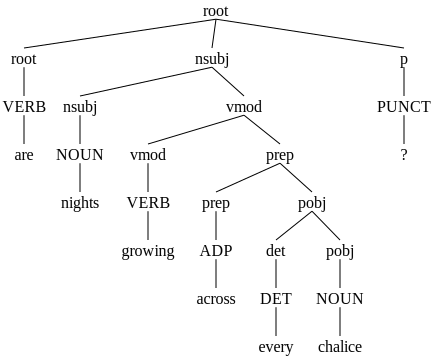

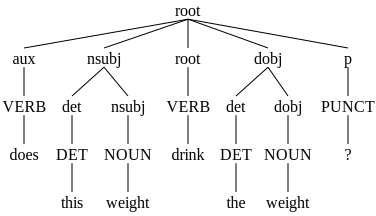

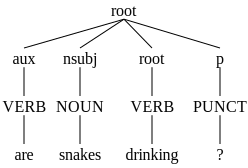

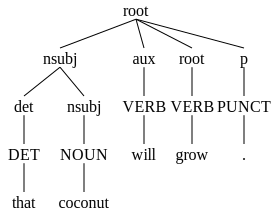

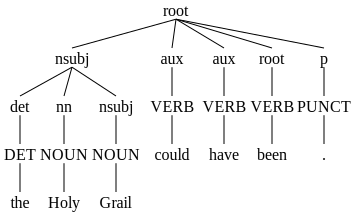

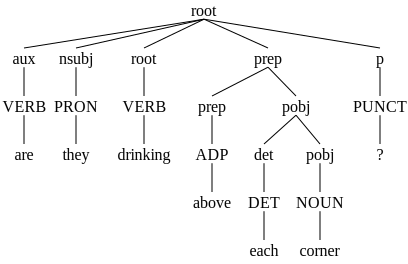

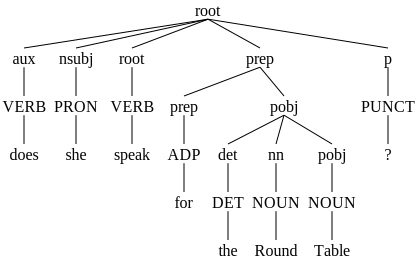

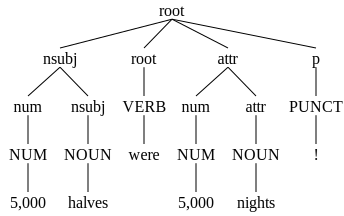

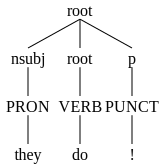

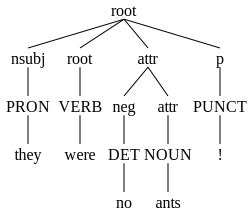

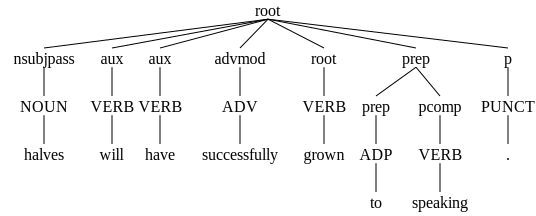

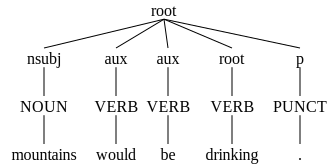

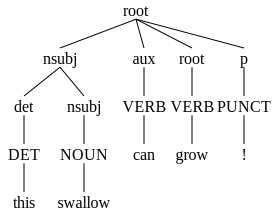

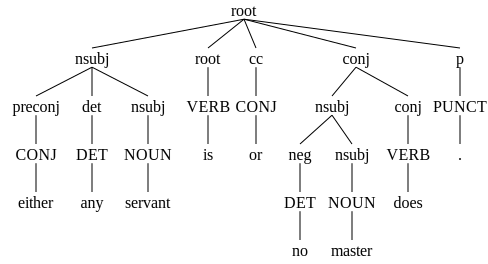

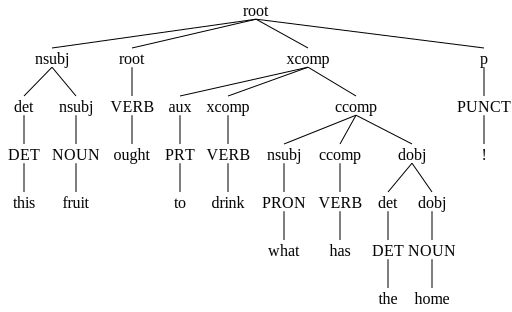

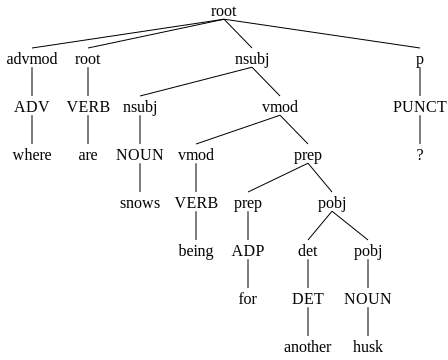

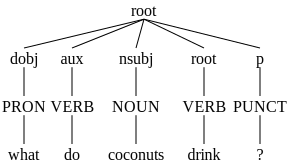

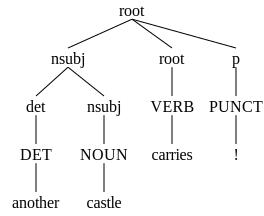

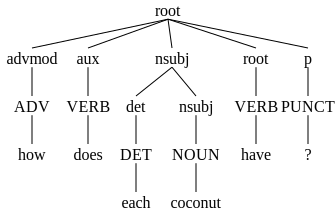

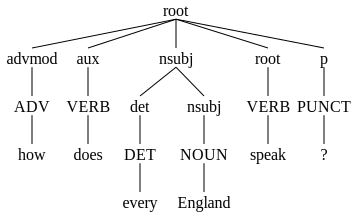

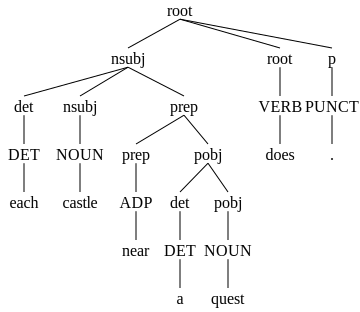

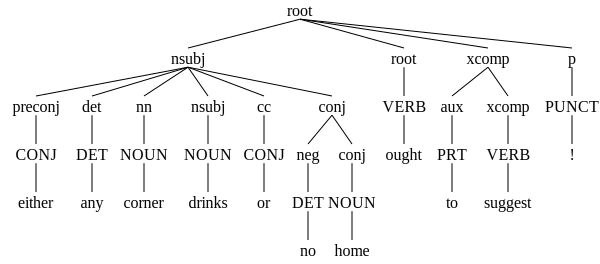

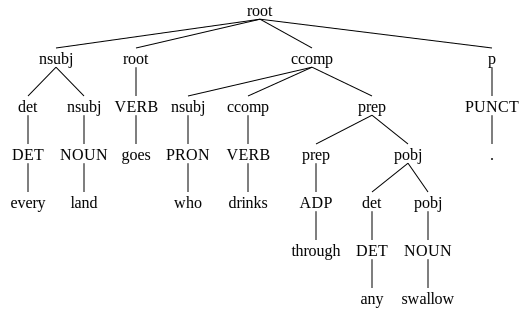

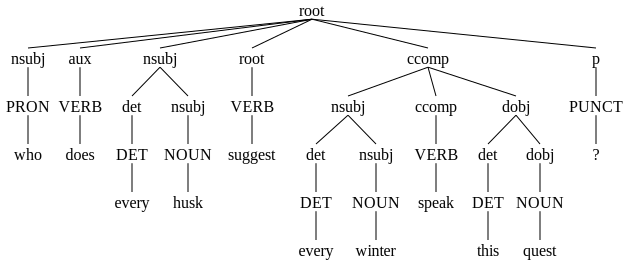

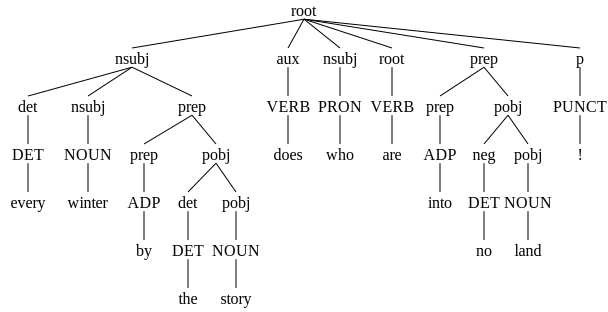

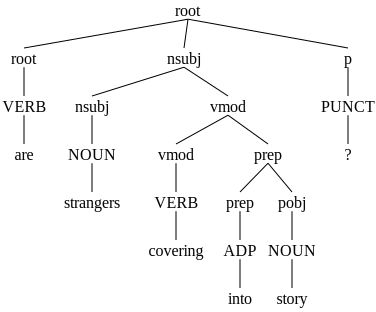

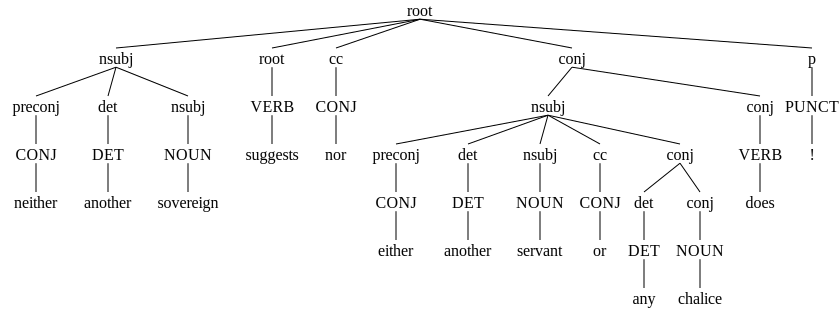

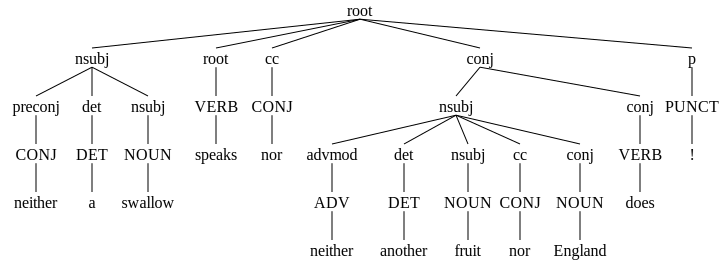

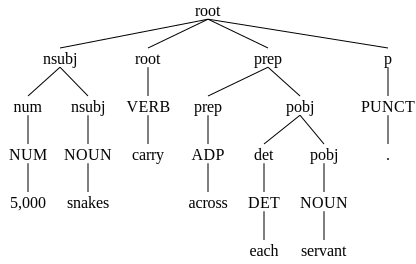

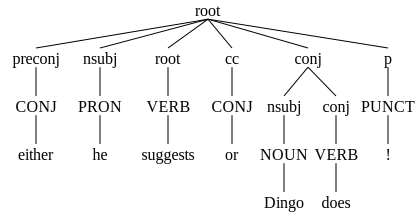

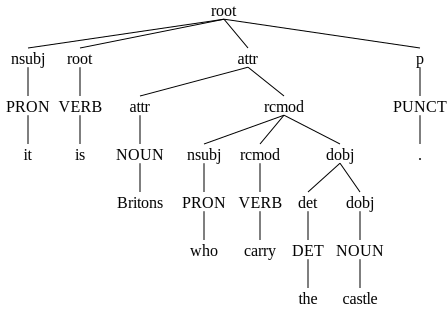

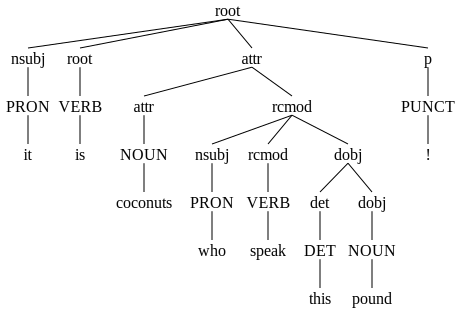

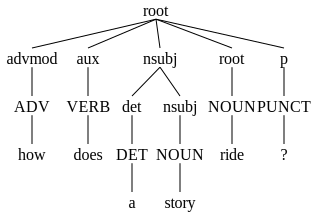

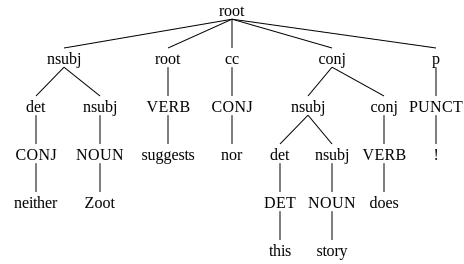

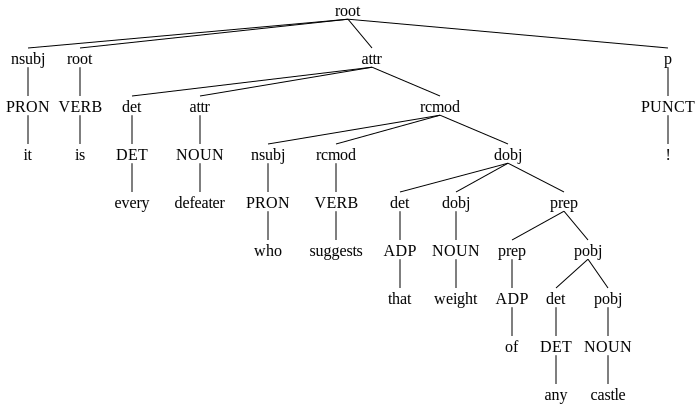

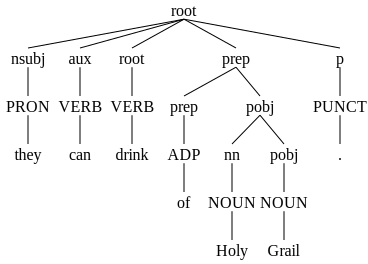

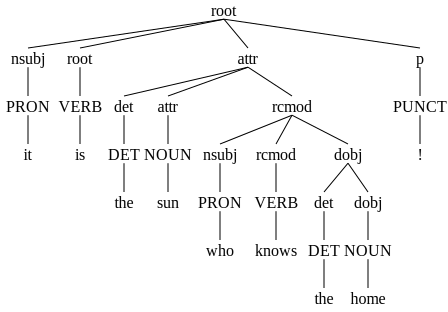

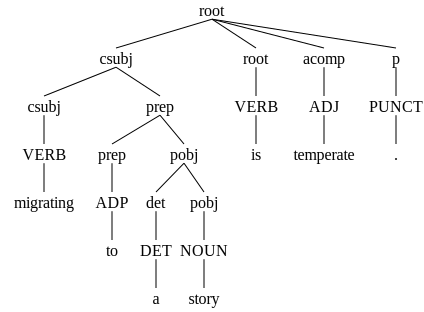

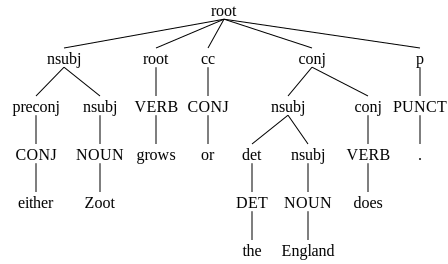

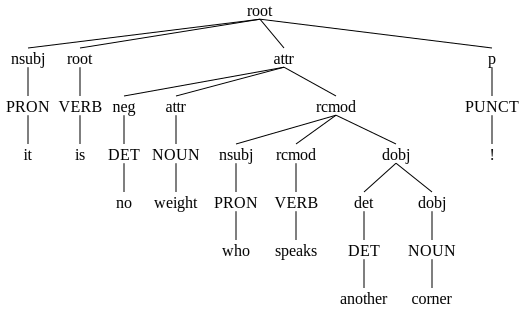

In [13]:
for tree in adversarial_trees_GC:
    display(tree)

In [14]:
import pickle

save_dir = "D:\\MIT\\Courses\\2023-Spring\\6.8630-NLP\\Final Project\\LLM CGW\\All Parse Trees\\Trees"

with open(save_dir+'\\GC_Adversarial_Trees.pkl', 'wb') as f:
    pickle.dump(adversarial_trees_GC, f)